In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import sys
import os

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path + "//src")
import dataManipulation as dm

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif


ModuleNotFoundError: No module named 'dataManipulation'

# KNN and Random Forest

In the following notebook I look at the transaction dataset and explore the different ways I can balance the data. I also test and tune KNN and Random Forest algorithms along side the different types of sampling. I mainly use Confusion Matrices to measure my results. My main goal is predicting more fraud cases without overfitting the models and keeping the overall accuracy relatively high.

Here I evaluate how the KNN performs with no data manipulation

In [166]:
transactions = dm.get_dataframe()
X = transactions.drop(columns=("Class"))
y = transactions["Class"]
#This is a preliminary split of the data, the main split happens below after the data is manipulated
X, y, X_train, y_train, X_test, y_test, X_val, y_val = dm.get_X_y_train_test_val(transactions, .3, .6, .1)
knn = KNeighborsClassifier(n_neighbors=4, weights='distance')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

Accuracy for kNearest neighbor without balancing or manipulating the data

In [167]:
print('KNN used on the unmanipulated data:')
print('Accuracy: %.8f' % accuracy_score(y_test, y_pred))

KNN used on the unmanipulated data:
Accuracy: 0.99860726


Notice the KNN is able to perform with a very high accuracy, but is unable to predict very many of the fraud cases.
Our goal is to predict a large amount of the fraud even if that means a small decrease in total accuracy.

Confusion matrix for the KNN:
[[85308     2]
 [  117    16]]


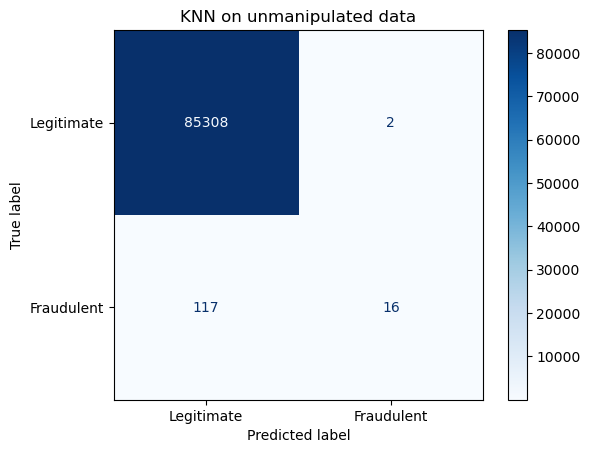

Percent of fraud found in the test data: 12.03


In [168]:
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix for the KNN:')
print(cm)
fraudPredicted = cm[1][1]
fraudMissed = cm[1][0]
#Plot the confusion matrix
dispCm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legitimate", "Fraudulent"])
dispCm.plot(cmap=plt.cm.Blues)
dispCm.ax_.set_title('KNN on unmanipulated data')
plt.grid(False)
plt.show()
#Find the percent of fraud predicted
percentOfFraud = (fraudPredicted/ (fraudPredicted + fraudMissed)) * 100
print('Percent of fraud found in the test data: %.2f' % percentOfFraud)

Next I evaluate how the Random Forest perfroms on the unmanipulated dataset

[77.98165137614679, 77.98165137614679, 77.06422018348624, 76.14678899082568, 78.89908256880734, 77.06422018348624, 77.06422018348624, 78.89908256880734, 79.81651376146789, 77.06422018348624, 78.89908256880734, 77.98165137614679, 78.89908256880734, 78.89908256880734, 77.98165137614679, 78.89908256880734, 77.98165137614679, 79.81651376146789, 78.89908256880734, 79.81651376146789, 77.98165137614679, 79.81651376146789, 77.98165137614679, 77.98165137614679]


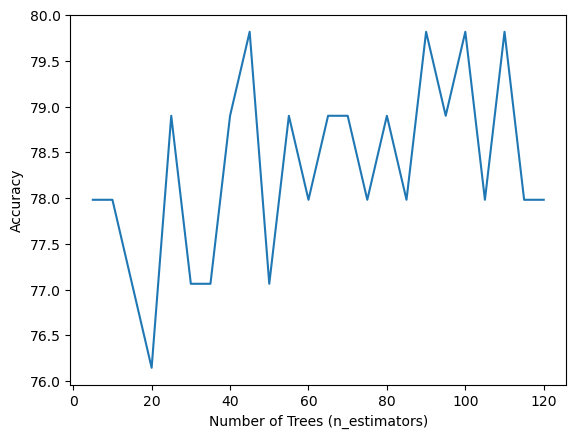

In [190]:
# As shown in IN3062 I explore which number of trees the Random forest works best for predicting fraud
# This will take a while to run, and the results fluctuate a lot.
# After running a couple of times it consistently performed best when around 100
accuracy_data = []
nums = []
for i in range(1,25):
    RF = RandomForestClassifier(n_estimators=i * 5,criterion="entropy")
    RF.fit(X_train, y_train)
    y_pred = RF.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    fraudPredicted = cm[1][1]
    fraudMissed = cm[1][0]
    accuracy = (fraudPredicted/ (fraudPredicted + fraudMissed)) * 100
    accuracy_data.append(accuracy)
    nums.append(i * 5)
    
print(accuracy_data)
plt.plot(nums,accuracy_data)
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.show()

RF used on the unmanipulated data:
Accuracy: 0.99957867
Confusion matrix for the RF:
[[85303     7]
 [   29   104]]


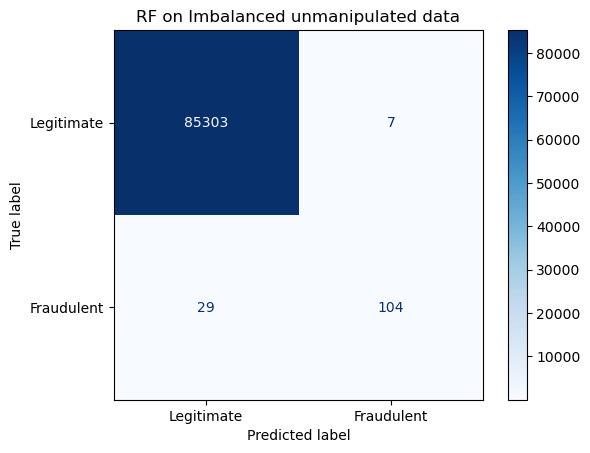

Percent of fraud found in the test data: 78.20


In [170]:
RFM = RandomForestClassifier(n_estimators=10,criterion="entropy")
RFM.fit(X_train, y_train)
y_pred = RFM.predict(X_test)

print('RF used on the unmanipulated data:')
print('Accuracy: %.8f' % accuracy_score(y_test, y_pred))
    
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix for the RF:')
print(cm)
fraudPredicted = cm[1][1]
fraudMissed = cm[1][0]
#Plot the confusion matrix
dispCm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legitimate", "Fraudulent"])
dispCm.plot(cmap=plt.cm.Blues)
dispCm.ax_.set_title('RF on Imbalanced unmanipulated data')
plt.grid(False)
plt.show()
percentMissed = (fraudPredicted/ (fraudPredicted + fraudMissed)) * 100
print('Percent of fraud found in the test data: %.2f' % percentMissed)

Notice without any data manipulation or many adjustments to our model the Random Forest does very well, and is also able to predict large amounts of fraud.

## Feature Selection

Also notice the large amount of variables, some of which are more important than others.
We find which variables would be ideal to drop using sklearn's mutual info classification which works much like KNN and measures the dependency betweeen variables.

Feature 0: 0.172295
Feature 1: 0.206702
Feature 2: 0.319817
Feature 3: 0.485920
Feature 4: 0.496655
Feature 5: 0.230726
Feature 6: 0.225406
Feature 7: 0.398762
Feature 8: 0.182115
Feature 9: 0.433578
Feature 10: 0.754915
Feature 11: 0.676573
Feature 12: 0.755473
Feature 13: 0.020722
Feature 14: 0.812479
Feature 15: 0.022554
Feature 16: 0.616196
Feature 17: 0.821175
Feature 18: 0.424003
Feature 19: 0.122823
Feature 20: 0.113724
Feature 21: 0.247155
Feature 22: 0.030574
Feature 23: 0.080608
Feature 24: 0.061192
Feature 25: 0.043756
Feature 26: 0.045979
Feature 27: 0.237749
Feature 28: 0.180021
Feature 29: 0.142401


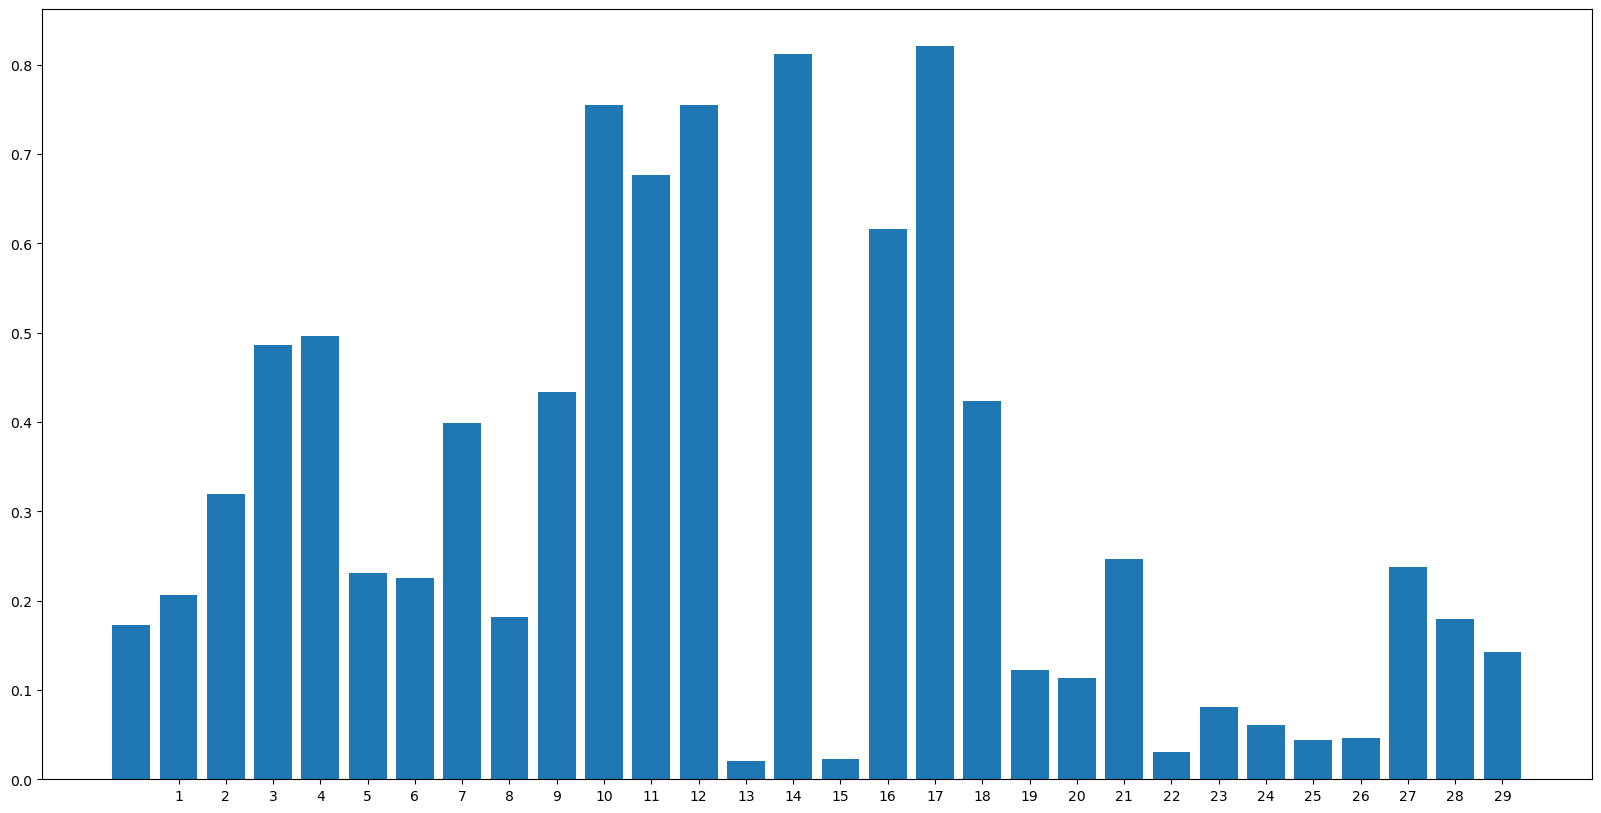

In [171]:
MI = mutual_info_classif(X, y, n_neighbors=4, copy = True)
for i in range(len(MI)):
    #Make the value easier to understand
    MI[i] = MI[i] * 100
    print('Feature %d: %f' % (i, MI[i]))
# plot the scores using a barplot
plt.subplots(figsize=(20, 10))
plt.bar([i for i in range(len(MI))], MI)
x = np.arange(1,30 ,1)
plt.xticks(x)
plt.show()

After checking the scores we see that the following features score low, are insignificant for our models, and can be dropped: 'V13','V15','V22','V23','V24','V25','V26'. For simplicity we have done this in the imported dataManipulation file and can import the edited dataset from that file.

In [172]:
#Use the transaction data with the data wrangling applied
transactions = dm.wrangled_dataframe()
#Split the data and the class
X = transactions.drop(columns=("Class"))
y = transactions["Class"]
#Split the data into training, test and validation data
#After experimenting with different ratios, we found it was optimal for our models to have 70% training data
X, y, X_train, y_train, X_test, y_test, X_val, y_val = dm.get_X_y_train_test_val(transactions, .2, .7, .1)

Next we check and see how the KNN and random forest perform on the manipulated data.

KNN used on the imbalanced data:
Accuracy: 0.99957867
Confusion matrix for the KNN:
[[56847     6]
 [   18    91]]


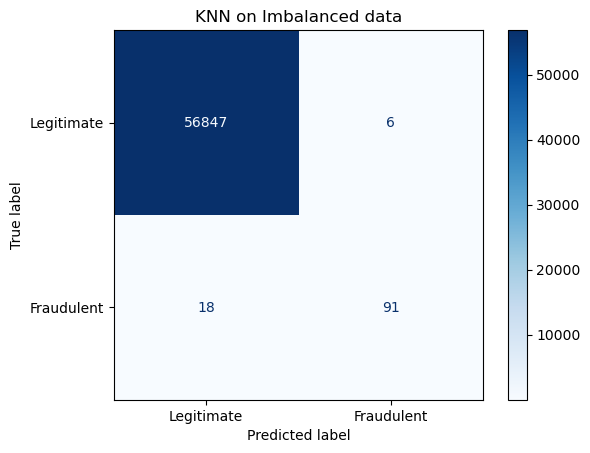

Percent of fraud found in the test data: 83.49


In [173]:
knn = KNeighborsClassifier(n_neighbors=4, weights='distance')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

"""
Accuracy for kNearest neighbor without balancing the data
"""
print('KNN used on the imbalanced data:')
print('Accuracy: %.8f' % accuracy_score(y_test, y_pred))
    
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix for the KNN:')
print(cm)
fraudPredicted = cm[1][1]
fraudMissed = cm[1][0]
#Plot the confusion matrix
dispCm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legitimate", "Fraudulent"])
dispCm.plot(cmap=plt.cm.Blues)
dispCm.ax_.set_title('KNN on Imbalanced data')
plt.grid(False)
plt.show()
percentMissed = (fraudPredicted/ (fraudPredicted + fraudMissed)) * 100
print('Percent of fraud found in the test data: %.2f' % percentMissed)

This drastically improved how much fraud our KNN model was able to predict 

Random Forest used on the unmanipulated data:
Accuracy: 0.99957867
Confusion matrix:
[[56851     2]
 [   22    87]]


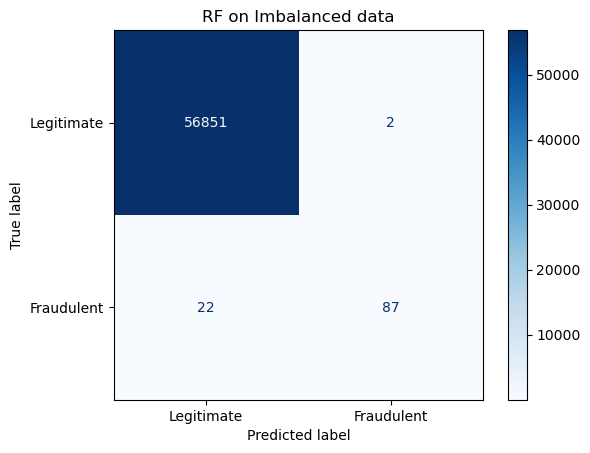

Percent of fraud found in the test data: 79.82


In [174]:
RFM = RandomForestClassifier(n_estimators=100,criterion="entropy")
RFM.fit(X_train, y_train)
y_pred = RFM.predict(X_test)

print('Random Forest used on the unmanipulated data:')
print('Accuracy: %.8f' % accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix:')
print(cm)
fraudPredicted = cm[1][1]
fraudMissed = cm[1][0]
dispCm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legitimate", "Fraudulent"])
dispCm.plot(cmap=plt.cm.Blues)
dispCm.ax_.set_title('RF on Imbalanced data')
plt.grid(False)
plt.show()
percentMissed = (fraudPredicted/ (fraudPredicted + fraudMissed)) * 100
print('Percent of fraud found in the test data: %.2f' % percentMissed)

However the data manipulation has little or no effect on how our Random Forest model performs.

Notice the large amount of legitimate cases:
(284315, 31)
Versus the tiny amount of fraudulent cases:
(492, 31)


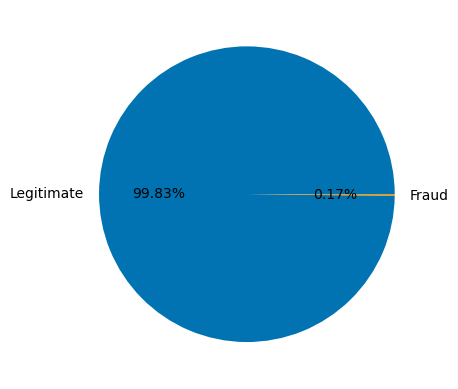

In [175]:
#Split the data based on its classifiers
legitimate = transactions[transactions["Class"] == 0]
fraud  = transactions[transactions["Class"] == 1]

"""
Show the exact number of legitimate data
and the exact amount of fraudulent data
"""
print('Notice the large amount of legitimate cases:')
print(legitimate.shape)
print('Versus the tiny amount of fraudulent cases:')
print(fraud.shape)

#Show in a pie chart the imbalance
pieData = transactions['Class'].value_counts(normalize=True) * 100
labels = ['Legitimate', 'Fraud']
colors = sns.color_palette('colorblind')[0:6]
plt.pie(pieData, labels = labels, colors = colors, autopct='%.2f%%')
plt.show()

By using different sampling techniques to balance the data I explore how I can get the RF and KNN to predict more fraud cases. I used the random undersample, random oversample, and SMOTE methods from the imblearn library. 
At: 
https://imbalanced-learn.org/stable/index.html
which also provides excellent documentation on how to use the methods.

## Upsampling

The first balancing technique I try is upsampling where the cases of the minority data are multiplied to balance the amount of each class.

In [176]:
# Upsampling the fraudulent data using method from our DataManipulation file
X_upsampled, y_upsampled = dm.upsample_train_data(X_train, y_train)
print('Using upsampling we increase the amount of fraudulent cases:')
print(y_upsampled[y_upsampled == 1].shape)
print(y_upsampled[y_upsampled == 0].shape)

Using upsampling we increase the amount of fraudulent cases:
(199026,)
(199026,)


Using the upsampled trained KNN:
Accuracy: 0.99922756
[[56825    28]
 [   16    93]]


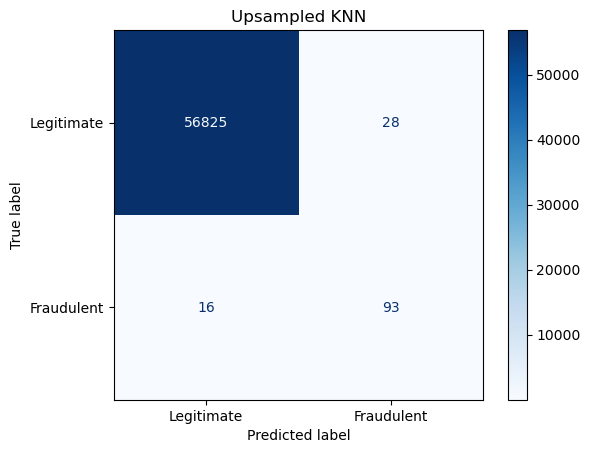

Percent of fraud found in the test data: 85.32


In [177]:
# Testing the KNN on the upsampled data
upsampledKnn = KNeighborsClassifier(n_neighbors=4, weights='distance')
upsampledKnn.fit(X_upsampled, y_upsampled)

y_pred = upsampledKnn.predict(X_test)

print('Using the upsampled trained KNN:')
print('Accuracy: %.8f' % accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)
fraudPredicted = cm[1][1]
fraudMissed = cm[1][0]
dispCm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legitimate", "Fraudulent"])
dispCm.plot(cmap=plt.cm.Blues)
dispCm.ax_.set_title('Upsampled KNN')
plt.grid(False)
plt.show()
percentMissed = (fraudPredicted/(fraudPredicted + fraudMissed)) * 100
print('Percent of fraud found in the test data: %.2f' % percentMissed)

The KNN is now able to predict 84 percent of the fraud cases

The upsampled RF used on the test data: 
Accuracy: 0.99956111
Confusion matrix:
[[56848     5]
 [   20    89]]


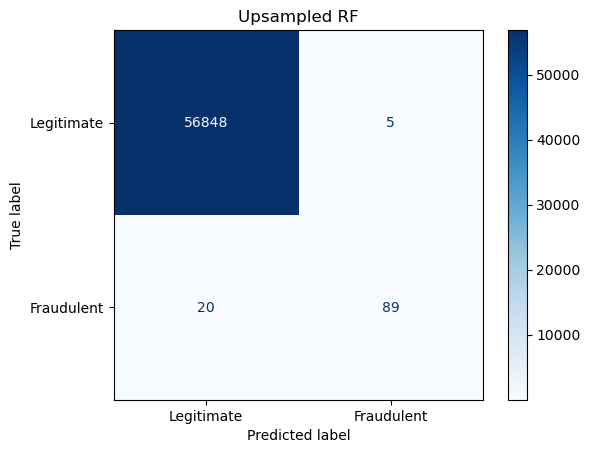

Percent of fraud found in the test data: 81.65


In [178]:
# Testing the Random Forest on the upsampled data 
upsampledRF = RandomForestClassifier(n_estimators=70,criterion="entropy")
upsampledRF.fit(X_upsampled, y_upsampled)

y_pred = upsampledRF.predict(X_test)

print('The upsampled RF used on the test data: ')
print('Accuracy: %.8f' % accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix:')
print(cm)
fraudPredicted = cm[1][1]
fraudMissed = cm[1][0]
dispCm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legitimate", "Fraudulent"])
dispCm.plot(cmap=plt.cm.Blues)
dispCm.ax_.set_title('Upsampled RF')
plt.grid(False)
plt.show()
percentMissed = (fraudPredicted/ (fraudPredicted + fraudMissed)) * 100
print('Percent of fraud found in the test data: %.2f' % percentMissed)

The random forest is still staying around 80 percent of fraud and hasn't shown much improvement.

## Undersampling

The second balancing technique I tried is undersampling or downsampling, where fewer cases of the majority data are used from the training data in order to match the amount minority cases.

In [179]:
#Downsample the training data using method from our DataManipulation file
X_downsampled, y_downsampled = dm.downsample_train_data(X_train, y_train)

print('Using downsampling we reduce the amount of legitimate cases and have an equal number:')
print(y_downsampled[y_downsampled == 1].shape)
print(y_downsampled[y_downsampled == 0].shape)
print('\n')

Using downsampling we reduce the amount of legitimate cases and have an equal number:
(338,)
(338,)




The downsampled KNN used on the test data: 
Accuracy: 0.96657421
Confusion matrix:
[[54956  1897]
 [    7   102]]


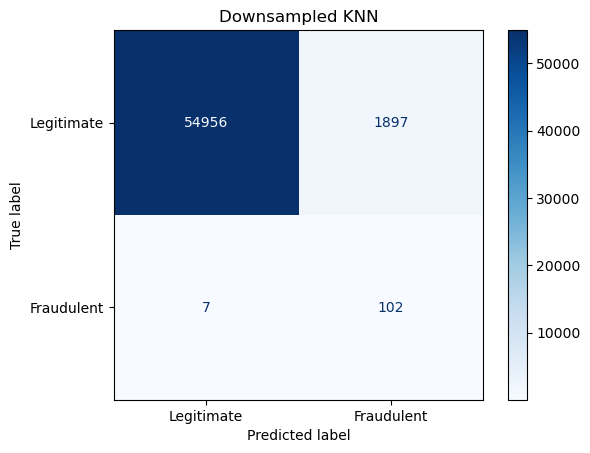

Percent of fraud found in the test data: 93.58


In [180]:
downsampledKnn = KNeighborsClassifier(n_neighbors=4, weights='distance')
downsampledKnn.fit(X_downsampled, y_downsampled)

y_pred = downsampledKnn.predict(X_test)

"""
Find how accurate the KNN is after the data it is trained on 
downsampled data.
"""
print('The downsampled KNN used on the test data: ')
print('Accuracy: %.8f' % accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix:')
print(cm)
fraudPredicted = cm[1][1]
fraudMissed = cm[1][0]
dispCm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legitimate", "Fraudulent"])
dispCm.plot(cmap=plt.cm.Blues)
dispCm.ax_.set_title('Downsampled KNN')
plt.grid(False)
plt.show()
percentMissed = (fraudPredicted/ (fraudPredicted + fraudMissed)) * 100
print('Percent of fraud found in the test data: %.2f' % percentMissed)

Using downsampling has made a big difference and our KNN is now able to predict 90 percent of the fraud cases. Notice the tradeoff is a decrease in overall accuracy and the model falsely labels more legitimate cases as fraud.

The downsampled RF used on the test data: 
Accuracy: 0.97730066
Confusion matrix:
[[55568  1285]
 [    8   101]]


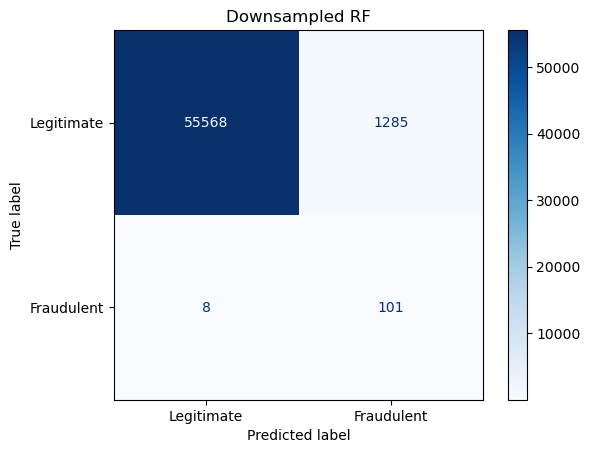

Percent of fraud found in the test data: 92.66


In [181]:
downsampledRF = RandomForestClassifier(n_estimators=70,criterion="entropy")
downsampledRF.fit(X_downsampled, y_downsampled)

y_pred = downsampledRF.predict(X_test)

"""
Find how accurate the RF is after the data it is trained on 
downsampled data.
"""
print('The downsampled RF used on the test data: ')
print('Accuracy: %.8f' % accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix:')
print(cm)
fraudPredicted = cm[1][1]
fraudMissed = cm[1][0]
dispCm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legitimate", "Fraudulent"])
dispCm.plot(cmap=plt.cm.Blues)
dispCm.ax_.set_title('Downsampled RF')
plt.grid(False)
plt.show()
percentMissed = (fraudPredicted/ (fraudPredicted + fraudMissed)) * 100
print('Percent of fraud found in the test data: %.2f' % percentMissed)

Downsampling has also improved our Random Forest model and the total accuracy doesn't go down as much as the downsampled KNN. 

## SMOTE

The last sampling technique we used was SMOTE(Synthetic Minority Over-sampling Technique), another way of upsampling the fraudulent data, which creates synthetic cases of the minority data in order to balance the dataset. This also helps to prevent over-fitting our model.

In [183]:
#Balance the data using the smote method from our DataManipulation file
X_smote, y_smote = dm.smote_train_data(X_train, y_train)

print('Using smote we balance the data:')
print(y_smote[y_smote == 1].shape)
print(y_smote[y_smote == 0].shape)
print('\n')

Using smote we balance the data:
(199026,)
(199026,)




Using the smote trained KNN:
Accuracy: 0.99792844
[[56749   104]
 [   14    95]]


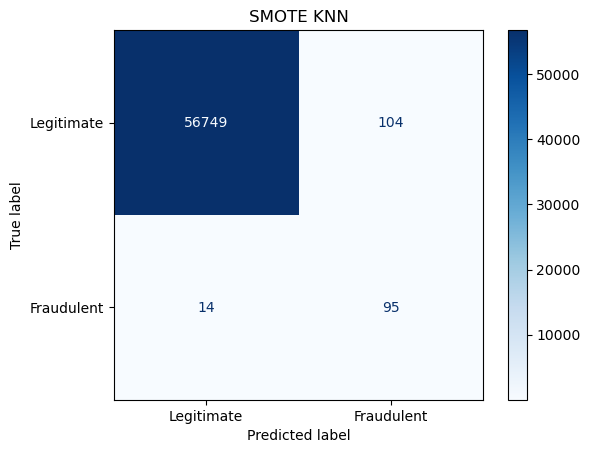

Percent of fraud found in the test data: 87.16


In [184]:
smoteKnn = KNeighborsClassifier(weights='distance')
smoteKnn.fit(X_smote, y_smote)

y_pred = smoteKnn.predict(X_test)

print('Using the smote trained KNN:')
print('Accuracy: %.8f' % accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)
fraudPredicted = cm[1][1]
fraudMissed = cm[1][0]
dispCm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legitimate", "Fraudulent"])
dispCm.plot(cmap=plt.cm.Blues)
dispCm.ax_.set_title('SMOTE KNN')
plt.grid(False)
plt.show()
percentMissed = (fraudPredicted/(fraudPredicted + fraudMissed)) * 100
print('Percent of fraud found in the test data: %.2f' % percentMissed)

The SMOTE KNN is more balanced than the downsampled KNN. It predicts a large amount of fraud cases without bringing down the overall accuracy.

Using the smote trained Random Forest:
Accuracy: 0.99954356
Precision: 0.92783505
Confusion matrix for Random Forest:
[[56846     7]
 [   19    90]]


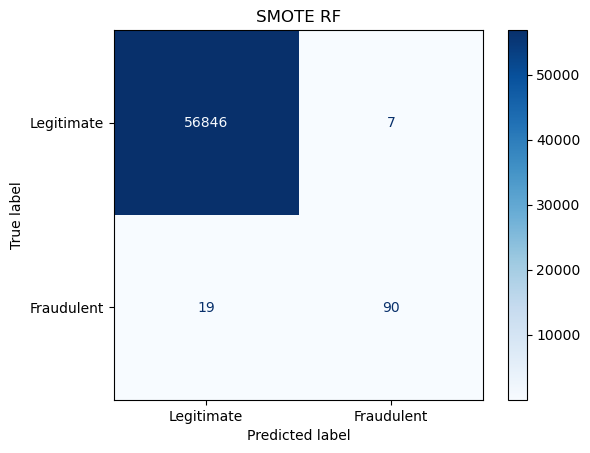

Percent of fraud found in the test data: 82.57


In [185]:
smoteRFM = RandomForestClassifier(n_estimators=10,criterion="entropy")
smoteRFM.fit(X_smote, y_smote)
y_pred = smoteRFM.predict(X_test)

print('Using the smote trained Random Forest:')
print('Accuracy: %.8f' % accuracy_score(y_test, y_pred))
print('Precision: %.8f' % precision_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix for Random Forest:')
print(cm)
fraudPredicted = cm[1][1]
fraudMissed = cm[1][0]
dispCm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legitimate", "Fraudulent"])
dispCm.plot(cmap=plt.cm.Blues)
dispCm.ax_.set_title('SMOTE RF')
plt.grid(False)
plt.show()
percentMissed = (fraudPredicted/ (fraudPredicted + fraudMissed)) * 100
print('Percent of fraud found in the test data: %.2f' % percentMissed)

## Validation 

Downsampled KNN:

Downsampled KNN
[[27479   957]
 [    5    40]]


Text(0.5, 1.0, 'Downsampled KNN')

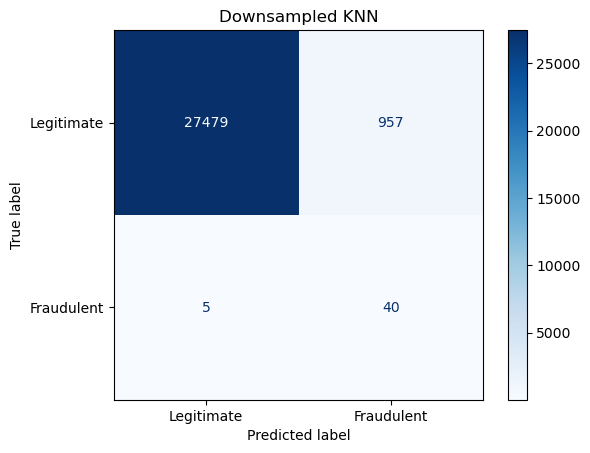

In [186]:
y_pred = downsampledKnn.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
print('Downsampled KNN')
print(cm)
dispCm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legitimate", "Fraudulent"])
dispCm.plot(cmap=plt.cm.Blues)
dispCm.ax_.set_title('Downsampled KNN')

Downsampled Random Forest:

Downsampled RF
[[27788   648]
 [    5    40]]


Text(0.5, 1.0, 'Downsampled RF')

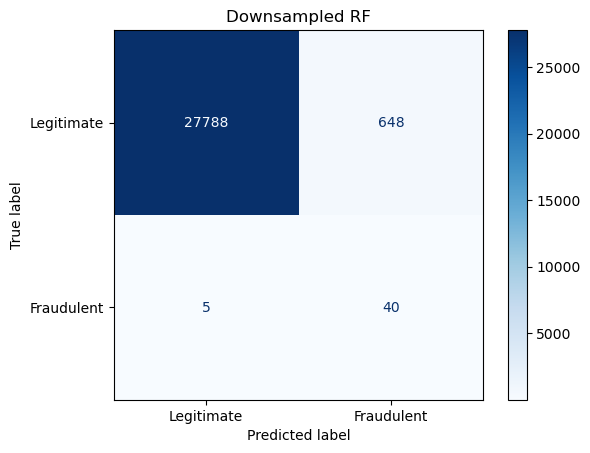

In [187]:
y_pred = downsampledRF.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
print('Downsampled RF')
print(cm)
dispCm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legitimate", "Fraudulent"])
dispCm.plot(cmap=plt.cm.Blues)
dispCm.ax_.set_title('Downsampled RF')

SMOTE KNN:

SMOTE KNN
[[28380    56]
 [    8    37]]


Text(0.5, 1.0, 'SMOTE KNN')

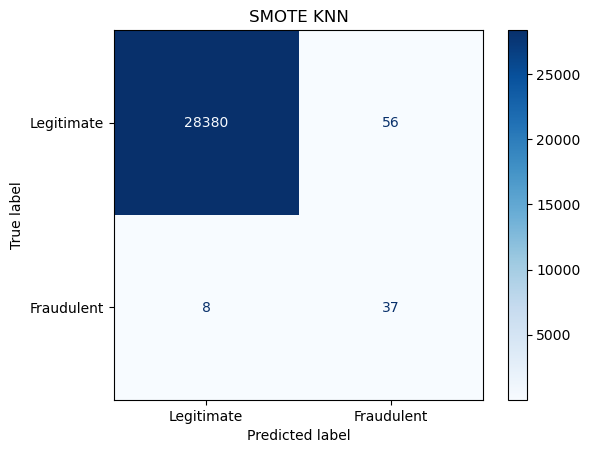

In [188]:
y_pred = smoteKnn.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
print('SMOTE KNN')
print(cm)
dispCm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legitimate", "Fraudulent"])
dispCm.plot(cmap=plt.cm.Blues)
dispCm.ax_.set_title('SMOTE KNN')

SMOTE Random Forest:

SMOTE RF
[[28432     4]
 [    8    37]]


Text(0.5, 1.0, 'SMOTE RF')

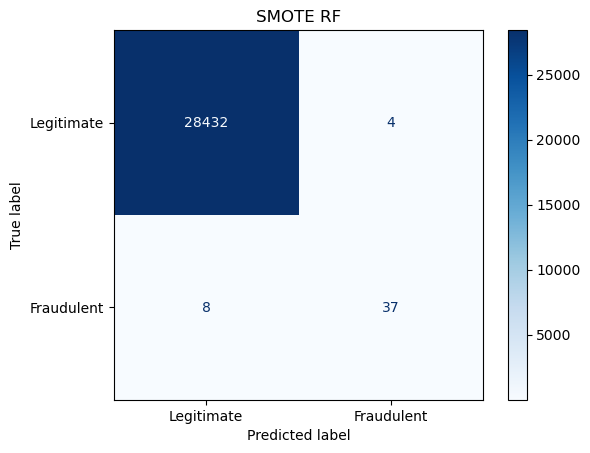

In [189]:
y_pred = smoteRFM.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
print('SMOTE RF')
print(cm)
dispCm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legitimate", "Fraudulent"])
dispCm.plot(cmap=plt.cm.Blues)
dispCm.ax_.set_title('SMOTE RF')